### Classify bird data set with TensorFlow. Project images to 3-D and visualize that in TensorBoard. (Image Classification using TensorFlow Pretrained Models)

In [1]:
import os,cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import regularizers
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
data_path = 'data'
data_dir_list = os.listdir(data_path)
print(data_dir_list)

['test', 'train', 'validation']


In [3]:
train_path = os.path.join(data_path,"train")
train_dir_list = os.listdir(train_path)
print(train_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


In [4]:
validation_path = os.path.join(data_path,"validation")
validation_dir_list = os.listdir(validation_path)
print(validation_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


In [5]:
test_path = os.path.join(data_path,"test")
test_dir_list = os.listdir(test_path)
print(test_dir_list)

['FLAME TANAGER', 'GOULDIAN FINCH', 'INDIGO BUNTING', 'LILAC ROLLER', 'MALACHITE KINGFISHER', 'NICOBAR PIGEON', 'PAINTED BUNTIG', 'PEACOCK', 'RAINBOW LORIKEET', 'TAIWAN MAGPIE']


Found 1100 images belonging to 10 classes.


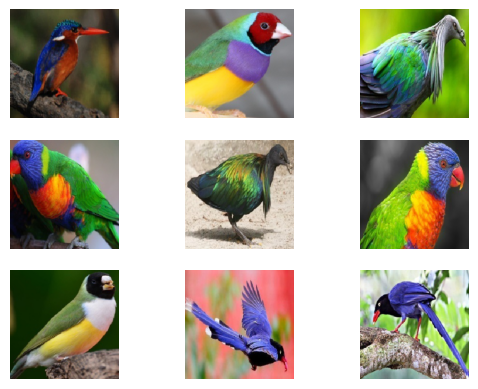

In [6]:
#-----------------------------------------------------------
# Visualizing some sample data
#-----------------------------------------------------------

sample_generator = ImageDataGenerator().flow_from_directory(train_path, shuffle=True)

plt.figure()
for i in range(9):
    # 3x3 grid
    sp=plt.subplot(330 + 1 + i)
    sp.axis('Off') # Don't show axes (or gridlines)
    batch = sample_generator.next()[0]
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [7]:
#-----------------------------------------------------------
# Prepare a csv file with training data
#-----------------------------------------------------------

class_to_labels={'FLAME TANAGER':0,'GOULDIAN FINCH':1,'INDIGO BUNTING':2,'LILAC ROLLER':3,'MALACHITE KINGFISHER':4, 
                 'NICOBAR PIGEON':5,'PAINTED BUNTIG':6,'PEACOCK':7,'RAINBOW LORIKEET':8, 'TAIWAN MAGPIE':9 }

df = pd.DataFrame(columns=['img_names', 'labels', 'class_names'])

for dataset in train_dir_list:
    img_list=os.listdir(os.path.join(train_path, dataset))
    print ('Loading dataset-'+'{}\n'.format(dataset))
    label=class_to_labels[dataset]
    for img in img_list:
        img_name=os.path.join(train_path,dataset,img)
       # annotations.append([image_name,dataset,label])
        df = df.append({'img_names': img_name, 'labels': label,'class_names': dataset},ignore_index=True)

df.to_csv(os.path.join('data_annotations.csv'))

Loading dataset-FLAME TANAGER

Loading dataset-GOULDIAN FINCH

Loading dataset-INDIGO BUNTING

Loading dataset-LILAC ROLLER

Loading dataset-MALACHITE KINGFISHER

Loading dataset-NICOBAR PIGEON

Loading dataset-PAINTED BUNTIG

Loading dataset-PEACOCK

Loading dataset-RAINBOW LORIKEET

Loading dataset-TAIWAN MAGPIE



In [8]:
#-----------------------------------------------------------
# Preparing the ImageDataGenerator
#-----------------------------------------------------------

train_imagedatagenerator = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_imagedatagenerator = ImageDataGenerator(rescale=1.0/255.)

train_iterator = train_imagedatagenerator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_iterator = validation_imagedatagenerator.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

dirs = train_iterator.class_indices
rdirs = {v:k  for k,v in dirs.items()}

Found 1100 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [9]:
from tensorflow.keras import applications
model = applications.VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#-----------------------------------------------------------
# Creating the Deep Learning Model
#-----------------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation

vgg16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers: layer.trainable=False
model=Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10,activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              1

In [11]:
#-----------------------------------------------------------
# Compiling the model
#-----------------------------------------------------------

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [12]:
#-----------------------------------------------------------
# Early stopping
#-----------------------------------------------------------

from keras.callbacks import ModelCheckpoint, EarlyStopping

metric = 'val_accuracy'
checkpoint = ModelCheckpoint(
    filepath=r"<path>/{}".format("myModelvGG16custom"), 
    monitor=metric,
    verbose=2, 
    save_best_only=True, 
    mode='max')

early = EarlyStopping(
    monitor=metric, 
    min_delta=0, 
    patience=3, 
    verbose=2, 
    mode='auto')

In [13]:
#-----------------------------------------------------------
# Training the model
#-----------------------------------------------------------

history = model.fit(
    train_iterator,
    validation_data=validation_iterator,
    #steps_per_epoch=100, #steps_per_epoch=(data_samples/batch_size),
    epochs=10,
    validation_steps=10,
    callbacks=[checkpoint,early],
    verbose=2)

Epoch 1/10
55/55 - 224s - loss: 2.5828 - accuracy: 0.4509 - val_loss: 4.3225 - val_accuracy: 0.4950

Epoch 00001: val_accuracy improved from -inf to 0.49500, saving model to C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom\assets
Epoch 2/10
55/55 - 224s - loss: 1.4527 - accuracy: 0.6600 - val_loss: 1.7333 - val_accuracy: 0.7100

Epoch 00002: val_accuracy improved from 0.49500 to 0.71000, saving model to C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom\assets
Epoch 3/10
55/55 - 229s - loss: 1.2765 - accuracy: 0.6864 - val_loss: 1.0469 - val_accuracy: 0.7850

Epoch 00003: val_accuracy improved from 0.71000 to 0.78500, saving model to C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom
INFO:tensorflow:Assets written to: C:/Users/AGM/HW3_tensorBoard\myModelvGG16custom\assets
Epoch 4/10
55/55 - 226s - loss: 1.0312 - accuracy: 0.7336 

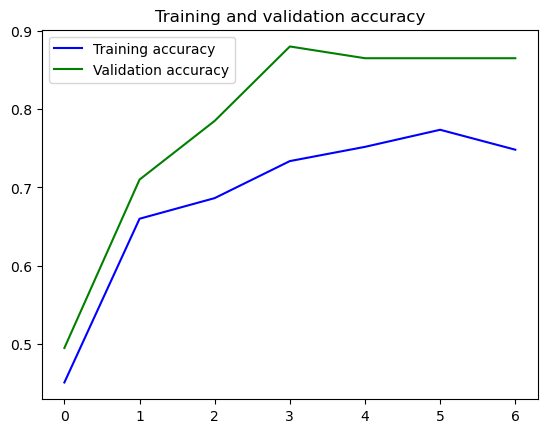

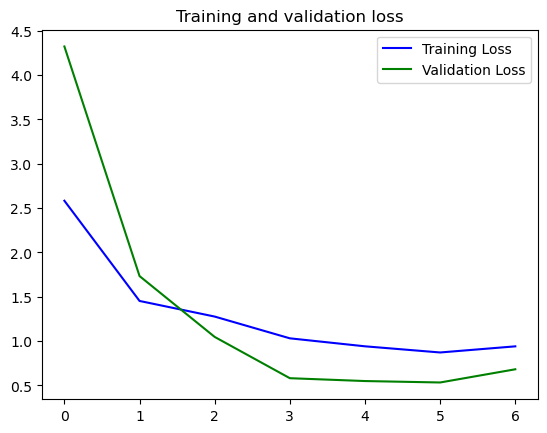

In [14]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_result(history)

In [15]:
#-----------------------------------------------------------
# Load the best saved model and pre-process the image and pass the image to the model for output.
#-----------------------------------------------------------

from keras.models import load_model

saved_model = load_model("<path>/myModelvGG16custom")

In [21]:
#-----------------------------------------------------------
# creating new model by eliminating the last layer
#-----------------------------------------------------------

from tensorflow.keras.models import Sequential

cust_model = Sequential()
for layer in saved_model.layers[:-3]: # just exclude last layer from copying
    cust_model.add(layer)
    
cust_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)             

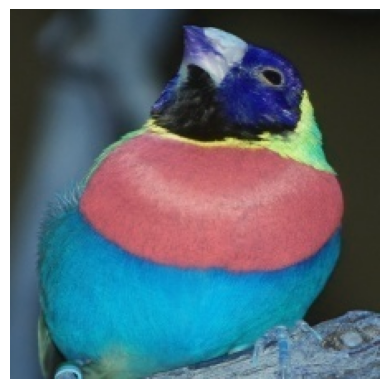

predict: GOULDIAN FINCH actual: GOULDIAN FINCH


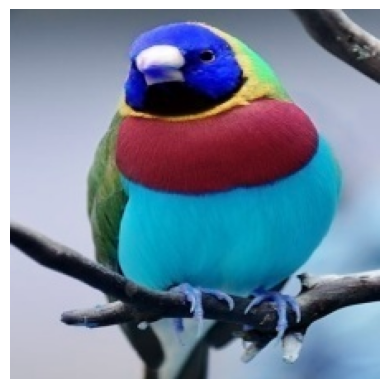

predict: GOULDIAN FINCH actual: GOULDIAN FINCH


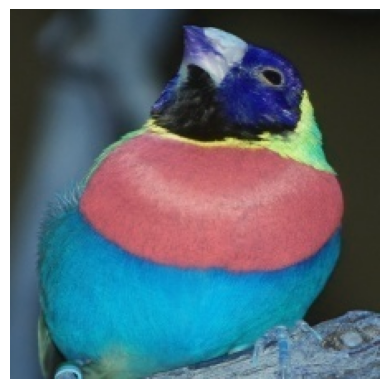

predict: GOULDIAN FINCH actual: GOULDIAN FINCH


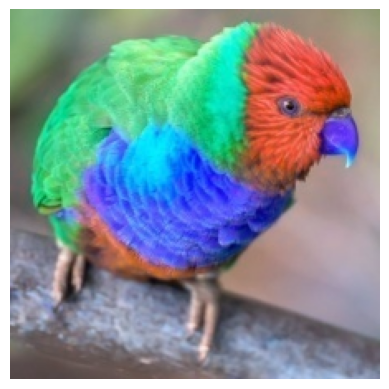

predict: RAINBOW LORIKEET actual: RAINBOW LORIKEET


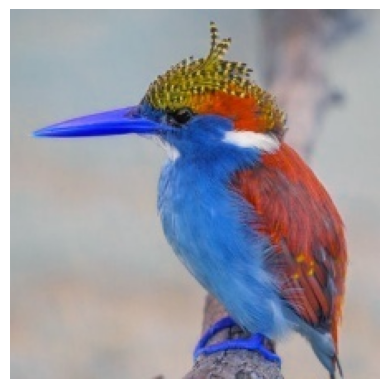

predict: MALACHITE KINGFISHER actual: MALACHITE KINGFISHER


In [20]:
#-----------------------------------------------------------
# Pass images for prediction
#-----------------------------------------------------------

from tensorflow.keras.preprocessing import image
import numpy as np
import random

for i in range(5):
    choice = random.randint(0,9)
    dir = rdirs[choice]
    #files = os.listdir(test_dir+'/'+dir)
    files=os.listdir(os.path.join(test_path, dir))
    img = random.choice(files)
    a = cv2.imread(test_path+'/'+dir+'/'+img)  
    a = cv2.resize(a,(224,224))
    plt.imshow(a)
    plt.axis("off")
    plt.show()
    a = np.array(a/255)
    answer = model.predict(np.array([a]))
    pred = np.argmax(answer)
    print("predict:",rdirs[pred],"actual:",rdirs[choice])

In [24]:
#-----------------------------------------------------------
# read the annotation file
#-----------------------------------------------------------

data = pd.read_csv('data_annotations.csv',usecols=['img_names', 'labels', 'class_names'])

In [25]:
#-----------------------------------------------------------
# Feature extraction 
#-----------------------------------------------------------

import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_image_features(image_file_name):
    
    image = load_img(image_file_name, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    features = cust_model.predict(image)
    
    return features

image_features_list=[]
for img in tqdm(data.img_names):
    image_features=get_image_features(img)
    image_features_list.append(image_features)    

image_features_arr=np.asarray(image_features_list)
del image_features_list # del to get free space
image_features_arr = np.rollaxis(image_features_arr,1,0)
image_features_arr = image_features_arr[0,:,:]
pickle.dump(image_features_arr, open('feature_vectors_1100Vgg16cust_samples.pkl', 'wb'))

100%|██████████| 1100/1100 [07:06<00:00,  2.58it/s]


In [26]:
#-----------------------------------------------------------
# define the log dor for saving checkpoints
#-----------------------------------------------------------

LOG_DIR = 'embedding_logsVgg16cust'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

In [27]:
#-----------------------------------------------------------
# prepare meta data file
#-----------------------------------------------------------

data = pd.read_csv('data_annotations.csv',usecols=['img_names', 'labels', 'class_names'])

metadata_file = open(os.path.join(LOG_DIR, 'metadata_10_classes.tsv'), 'w')
metadata_file.write('Class\tName\n')

for label,name in zip(data.labels,data.class_names):
    metadata_file.write('{}\t{}\n'.format(label,name))
metadata_file.close()

In [28]:
#-----------------------------------------------------------
#prepare sprite images 
#-----------------------------------------------------------

img_data=[]
for img in tqdm(data.img_names):
    input_img=cv2.imread(img)
    input_img_resize=cv2.resize(input_img,(150,150))
    img_data.append(input_img_resize) 
img_data = np.array(img_data)

100%|██████████| 1100/1100 [00:02<00:00, 369.52it/s]


In [29]:
#-----------------------------------------------------------
# Taken from: https://github.com/tensorflow/tensorflow/issues/6322
#-----------------------------------------------------------

def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [30]:
sprite = images_to_sprite(img_data)
cv2.imwrite(os.path.join(LOG_DIR, 'sprite_10_classes.png'), sprite)
print('sprite_10_classes.png')

sprite_10_classes.png


In [31]:
#-----------------------------------------------------------
# Load features
#-----------------------------------------------------------
with open('feature_vectors_1100Vgg16cust_samples.pkl', 'rb') as f:
    feature_vectors = pickle.load(f)
#feature_vectors = np.loadtxt('feature_vectors_400_samples.txt')
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

features = tf.Variable(feature_vectors, name='features')

feature_vectors_shape: (1100, 4096)
num of images: 1100
size of individual feature vector: 4096


In [32]:
#-----------------------------------------------------------
# Create a checkpoint from embedding, the filename and key are name of the tensor
#-----------------------------------------------------------

checkpoint = tf.train.Checkpoint(embedding=features)
checkpoint.save(os.path.join(LOG_DIR, "embedding.ckpt"))

'embedding_logsVgg16cust\\embedding.ckpt-1'

In [33]:
#-----------------------------------------------------------
# Set up config
#-----------------------------------------------------------

from tensorboard.plugins import projector

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path =  'metadata_10_classes.tsv'
embedding.sprite.image_path =  'sprite_10_classes.png'
embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])

projector.visualize_embeddings(LOG_DIR, config)

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir embedding_logs